In [6]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import multivariate_normal as mn
from scipy.stats import norm
import statsmodels.api as sm

In [107]:
def custom(data, l, tol=1e-5, verbose=False):
    n = data.shape[0]   # sample size
    m = data.shape[1]   # total number of variables
    k = (l/2)*(2*m-l-1) # number of elements of R considered
    if m > 1 and k > 0:
        R = np.corrcoef(data.T)      
        included = np.triu(R, k=1)
        excluded = np.concatenate([np.concatenate([np.triu(R[:(m-l),:(m-l)], k=1), 
                                                   np.zeros(((m-l), l))], axis=1), 
                                   np.zeros((l,m))], axis=0)
        if verbose:
            print(pd.DataFrame(included - excluded))
        t_nm = (np.sum(np.square(included - excluded))) - k/n
        s_nm = (2*k*(n-1))/((n**2)*(n+2))
        return t_nm/np.sqrt(s_nm)
    
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0

In [121]:
cors = np.linspace(0, 1, 5)
ms = [10]
ls = [5]
ns = [100]
ks = [1000]
alphas = [0.05]

results = pd.DataFrame()

for cor, m, l, n, k, alpha in itertools.product(cors, ms, ls, ns, ks, alphas):
    if l < m:
        rejected = 0
        for i in range(k):
            cov = np.identity(m-l)
            cov[cov == 0] = cor
            cor_sample = mn.rvs(cov=cov, size=n).reshape(n, -1)
            uncor_sample = mn.rvs(cov=np.identity(l), size=n).reshape(n, -1)
            sample = np.concatenate([cor_sample, uncor_sample], axis=1)

            t = custom(sample, l)
            # if not valid:
            if np.abs(t) > norm.ppf(1-(alpha/2)):
                rejected += 1

        emp_alpha = rejected/k

        result = {'c': cor, 'm': m, 'l': l, 'n': n, 'k': k, 'a': alpha, 'es': emp_alpha, 'd': np.abs(alpha)-emp_alpha}
        results = results.append(result, ignore_index=True)

results = results.loc[:,['es', 'a', 'd', 'n', 'c', 'm', 'l', 'k']]

In [122]:
results['n'] = results['n'].astype(int)
results['m'] = results['m'].astype(int)
results['l'] = results['l'].astype(int)
results['k'] = results['k'].astype(int)

In [26]:
results.to_csv('../text/latex/algo/files/test_validation.csv', index=False, float_format='%.3f')

In [45]:
results.sort_values(by='d', ascending=True)

,es,a,d,n,c,m,l,k
77,0.375,0.05,-0.325,1000,0.8,12,2,1000
73,0.371,0.05,-0.321,50,0.8,12,2,1000
75,0.365,0.05,-0.315,100,0.8,12,2,1000
81,0.331,0.05,-0.281,100,0.8,12,4,1000
79,0.327,0.05,-0.277,50,0.8,12,4,1000
...,...,...,...,...,...,...,...,...
23,0.044,0.05,0.006,1000,0.1,8,6,1000
13,0.044,0.05,0.006,50,0.1,8,4,1000
17,0.041,0.05,0.009,1000,0.1,8,4,1000
1,0.041,0.05,0.009,50,0.1,4,2,1000


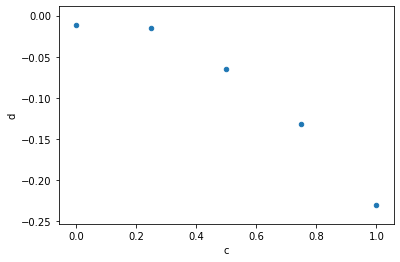

In [123]:
results.plot(x='c', y='d', kind='scatter')

In [102]:
y = results[results['a'] == 0.05].loc[:,'d']
x = results[results['a'] == 0.05].loc[:,['n', 'm', 'l', 'c']]
model = sm.OLS(y,x)
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      d   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     34.79
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           3.45e-10
Time:                        22:40:15   Log-Likelihood:                 57.376
No. Observations:                  36   AIC:                            -106.8
Df Residuals:                      32   BIC:                            -100.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
n           5.945e-06   1.99e-05      0.299      0.767   -3.46e-05    4.65e-05
m             -0.0077      0.003     -2.921      0.006      -0.013      -0.002
l              0.0217      0.004      5.595      0.000       0.014       0.030
c             -0.2273      0.027     -8.542      0.000      -0.281      -0.173
==============================================================================
Omnibus:                        3.022   Durbin-Watson:                   0.655
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.157
Skew:                          -0.424   Prob(JB):                        0.340
Kurtosis:                       2.152   Cond. No.                     1.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
cor = 0.8
m = 7
l = 1
n = 100000

cov = np.identity(m-l)
cov[cov == 0] = cor
cor_sample = mn.rvs(cov=cov, size=n).reshape(n, -1)
uncor_sample = mn.rvs(cov=np.identity(l), size=n).reshape(n, -1)
sample = np.concatenate([cor_sample, uncor_sample], axis=1)

t = custom(sample, l, verbose=True)
t

     0    1    2    3    4    5         6
0  0.0  0.0  0.0  0.0  0.0  0.0  0.006482
1  0.0  0.0  0.0  0.0  0.0  0.0  0.008975
2  0.0  0.0  0.0  0.0  0.0  0.0  0.008440
3  0.0  0.0  0.0  0.0  0.0  0.0  0.004829
4  0.0  0.0  0.0  0.0  0.0  0.0  0.008021
5  0.0  0.0  0.0  0.0  0.0  0.0  0.007195
6  0.0  0.0  0.0  0.0  0.0  0.0  0.000000


7.887478768201569

In [136]:
pd.DataFrame(np.corrcoef(np.concatenate([cor_sample, uncor_sample], axis=1).T))

,0,1,2,3,4,5,6
0,1.000000,0.794465,0.789408,0.769561,0.797074,0.793726,0.018862
1,0.794465,1.000000,0.788275,0.786658,0.800403,0.795604,0.038652
2,0.789408,0.788275,1.000000,0.780784,0.796948,0.799650,0.033743
3,0.769561,0.786658,0.780784,1.000000,0.780326,0.773856,0.031879
4,0.797074,0.800403,0.796948,0.780326,1.000000,0.791583,0.035799
5,0.793726,0.795604,0.799650,0.773856,0.791583,1.000000,0.016738
6,0.018862,0.038652,0.033743,0.031879,0.035799,0.016738,1.000000


Problem is that if the unrestricted elements are highly correlated, then if one sample correlation between the restricted and unrestricted elements happens to be high ... so will the rest ... and so will the test statistic

In [158]:
cov = 0.8
m = 7
l = 1
n = 100000
k = 100
rejected = 0
for i in range(k):
    cov = np.identity(m-l)
    cov[cov == 0] = cor
    cor_sample = mn.rvs(cov=cov, size=n).reshape(n, -1)
    uncor_sample = mn.rvs(cov=np.identity(l), size=n).reshape(n, -1)
    sample = np.concatenate([cor_sample, uncor_sample], axis=1)

    t = custom(sample, l)
    if np.abs(t) > norm.ppf(1-(alpha/2)):
        rejected += 1

        
print(rejected/k)

0.09
